In [1]:
import folium
import pandas as pd
import pickle
import numpy as np

In [2]:
file = open('./pickles/house_latlong.p','rb')
df = pickle.load(file)

In [3]:
ave_lat = np.mean(df.latitude)
ave_long = np.mean(df.longitude)
(ave_lat, ave_long)

(42.03438790059312, -93.64255447330521)

In [4]:
neighborhoods = df[~np.isnan(df.latitude)].groupby('Neighborhood')[['latitude','longitude']].mean() #get center of neighborhood
neighborhoods['num_houses'] = df.Neighborhood.value_counts()
nieghborhoods = neighborhoods.reset_index()

In [5]:
m = folium.Map(location=[ave_lat, ave_long],tiles='Stamen Toner')
for i in range(0,neighborhoods.shape[0]):
    folium.Circle(location = [neighborhoods.latitude[i], neighborhoods.longitude[i]], 
                  radius = int(neighborhoods.num_houses[i]), popup = nieghborhoods.Neighborhood[i]).add_to(m)
m    
    #color the circles

In [6]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
KNR = KNeighborsRegressor()

In [8]:
#dropping NA values with lat long. 
df = df[~np.isnan(df.latitude)]
#redo this with the cosine(42) multiplication. 
df['e_long'] = df['longitude']*np.cos(np.radians(42))

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis = 1),df['SalePrice'], test_size = .2)

In [16]:
params = {'n_neighbors':range(1,100)}
gcv_knr = GridSearchCV(KNR,param_grid = params)

In [17]:
gcv_knr.fit(x_train[['latitude','e_long']],y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [18]:
gcv_knr.best_score_, gcv_knr.best_estimator_

(0.6807084705830003,
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform'))

In [22]:
gcv_knr.score(x_test[['latitude','e_long']],y_test)

0.6895872226852316

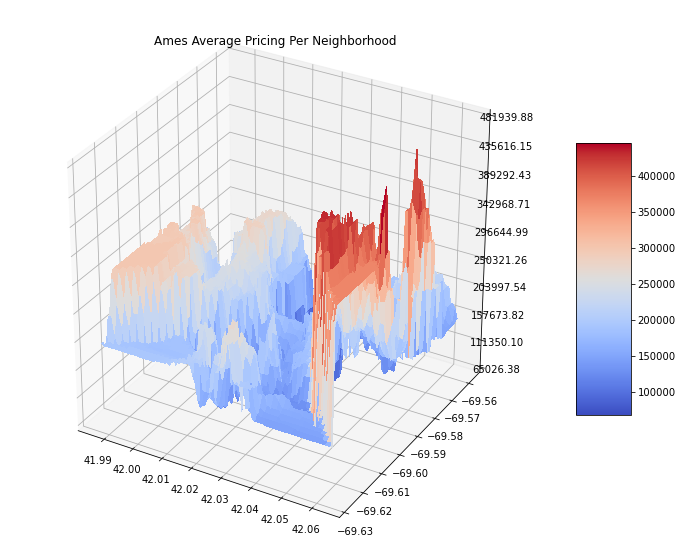

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

A = np.linspace(min(x_train.latitude),max(x_train.latitude),100)

B = np.linspace(min(x_train.e_long),max(x_train.e_long),100)
A, B = np.meshgrid(A, B)
C = gcv_knr.predict(np.transpose(np.array([A.flatten(), B.flatten()]))).reshape(A.shape)

# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Ames Average Pricing Per Neighborhood')
plt.show()

In [ ]:
from folium.plugins import HeatMap
m = folium.Map(location=[ave_lat, ave_long],tiles='Stamen Toner')
x_train['predict'] = KNR.predict(x_train[['latitude','e_long']])/50000
HeatMap(x_train[['latitude','longitude','predict']].values).add_to(m)
m

In [327]:
len(np.unique(KNR.predict(x_train[['latitude','e_long']])))

873

In [13]:
gcv_knr.score(x_train[['latitude','e_long']],y_train), KNR.score(x_test[['latitude','e_long']],y_test) #obviously can make this better. Do a grid search, just have to

(0.6052531824935966, 0.5802691181217953)

In [33]:
lam = .5
x_train['residuals'] = y_train - lam*gcv_knr.predict(x_train[['latitude','e_long']])

In [19]:
x_train.residuals

551     -14955.0
1499     18770.0
1700       659.6
2010      3810.0
445      40450.2
          ...   
1845    -12245.0
1545      3550.0
1399     29610.0
2411     -5690.0
1117    115120.0
Name: residuals, Length: 2029, dtype: float64

### SVR - with RBF Kernels

In [53]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
SVR_map = make_pipeline(StandardScaler(),SVR(epsilon =.0001 ,C = 100000)) #NEED TO USE GRIDSEARCH!!! Maybe fit toooo
SVR_map.fit(x_train[['latitude','e_long']],y_train)
SVR_map.score(x_train[['latitude','e_long']], y_train), SVR_map.score(x_test[['latitude','e_long']],y_test)

In [90]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis = 1),df['SalePrice'], test_size = .2)

SVR_map = SVR(kernel='rbf') #NEED TO USE GRIDSEARCH!!! Maybe fit toooo

parameters = {'C' : [100,1000,10000,100000,1000000,10000000], 'epsilon' : [.01,.1,1,10,100,1000], 
              'gamma' : [.001,.01,.1,1,10,100,1000,10000,1000000]}

GD_SVR = GridSearchCV(SVR_map,param_grid=parameters)

GD_SVR.fit(x_train[['latitude','e_long']],y_train)

#SVR_map.fit(x_train[['latitude','e_long']],y_train)
#SVR_map.score(x_train[['latitude','e_long']], y_train), SVR_map.score(x_test[['latitude','e_long']],y_test)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [100, 1000, 10000, 100000, 1000000, 10000000],
                         'epsilon': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                                   1000000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [91]:
[GD_SVR.cv_results_['params'][x] for x in [i for i, j in enumerate(GD_SVR.cv_results_['mean_test_score']) if j>.6]]
GD_SVR.best_estimator_


SVR(C=1000000, cache_size=200, coef0=0.0, degree=3, epsilon=1000, gamma=10000,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

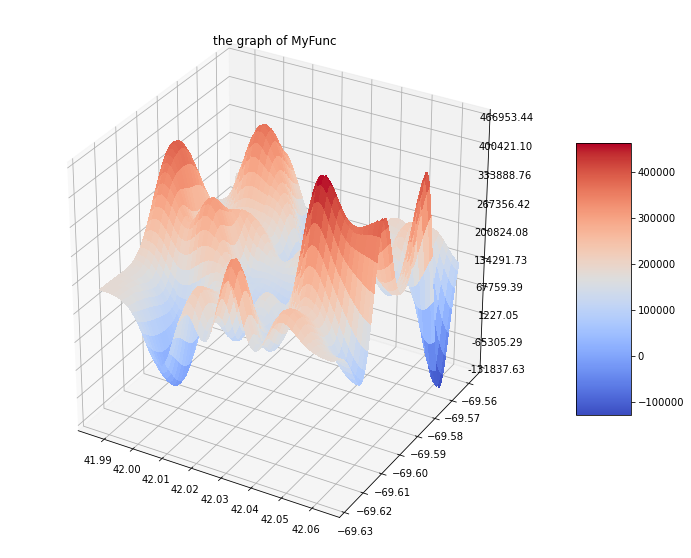

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

A = np.linspace(min(x_train.latitude),max(x_train.latitude),100)

B = np.linspace(min(x_train.e_long),max(x_train.e_long),100)
A, B = np.meshgrid(A, B)
C = GD_SVR.predict(np.transpose(np.array([A.flatten(), B.flatten()]))).reshape(A.shape)

# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('the graph of MyFunc')
plt.show()

In [18]:
x_train['residuals'] = y_train - SVR_map.predict(x_train[['latitude','e_long']])

array([[42.03231092, 42.06110343, 42.04566291, ..., 42.0550751 ,
        42.04376906, 42.01606057],
       [42.03231092, 42.06110343, 42.04566291, ..., 42.0550751 ,
        42.04376906, 42.01606057],
       [42.03231092, 42.06110343, 42.04566291, ..., 42.0550751 ,
        42.04376906, 42.01606057],
       ...,
       [42.03231092, 42.06110343, 42.04566291, ..., 42.0550751 ,
        42.04376906, 42.01606057],
       [42.03231092, 42.06110343, 42.04566291, ..., 42.0550751 ,
        42.04376906, 42.01606057],
       [42.03231092, 42.06110343, 42.04566291, ..., 42.0550751 ,
        42.04376906, 42.01606057]])

### Potentially evaluate gradient boosting

In [34]:
from sklearn.linear_model import Ridge, LinearRegression

house_base_reduced = x_train.loc[:,['GrLivArea','residuals','LotArea',
                      'OverallQual','OverallCond','YearBuilt','YearRemodAdd',
                      'TotalBsmtSF','Fireplaces','GarageArea',
                      'MoSold','YrSold']]
house_base_reduced = pd.get_dummies(house_base_reduced)

house_base_reduced['Age'] = house_base_reduced['YrSold'] - house_base_reduced['YearBuilt'] #think about combining into one
house_base_reduced['YrSinceRemod'] =  house_base_reduced['YrSold'] - house_base_reduced['YearRemodAdd']
house_base_reduced = house_base_reduced.drop(['YrSold','YearBuilt','YearRemodAdd'],axis = 1)

In [35]:
lm_residuals = Ridge()

In [36]:
house_base_reduced = house_base_reduced.dropna()

In [37]:
lm_residuals.fit(house_base_reduced.drop('residuals', axis =1), house_base_reduced['residuals'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [38]:
import statsmodels.api as sm
x = sm.add_constant(house_base_reduced.drop('residuals', axis =1))
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(house_base_reduced['residuals'], x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     586.2
Date:                Fri, 28 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:58:33   Log-Likelihood:                -23449.
No. Observations:                2027   AIC:                         4.692e+04
Df Residuals:                    2016   BIC:                         4.698e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.775e+04   5369.806    -18.203   

### Unsupervised Clustering

Similar analysis as above but instead use an unsupervised clustering algorithm, then just the average price in that region (think about the type of average to use). Orrrrrrrr do a separate analysis on each cluster? Idk I don't like this. 